In [2]:
import pandas as pd
import numpy as np
import datetime
import shutil
import tensorflow as tf
from matplotlib import rcParams
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler,LabelEncoder
from keras.callbacks import EarlyStopping,TensorBoard,ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D ,Conv2D, Flatten, GlobalMaxPool2D
from keras.applications import Xception,EfficientNetB3,VGG19
from keras.applications.xception import preprocess_input
from keras.models import Model
from keras.initializers import HeNormal
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import numpy as np
from keras.models import Sequential
import os
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [3]:
base_dir='/kaggle/input/eye-diseases/OCT2024 (2)/OCT2024/'
train_dir=base_dir+'train'
val_dir=base_dir+'val'
test_dir=base_dir+'test'

Generator Setup and Data Augmentation

In [4]:
img_width,img_height=224,224
batch_size=128
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.13,
    height_shift_range=0.13,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    brightness_range=[0.8,1.2]
)
val_datagen=ImageDataGenerator(rescale=1. /255)
test_datagen=ImageDataGenerator(rescale=1. /255)

In [5]:
train_generator=train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_generator=test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10393 images belonging to 4 classes.
Found 1297 images belonging to 4 classes.
Found 1297 images belonging to 4 classes.


Augmented Data Inspection

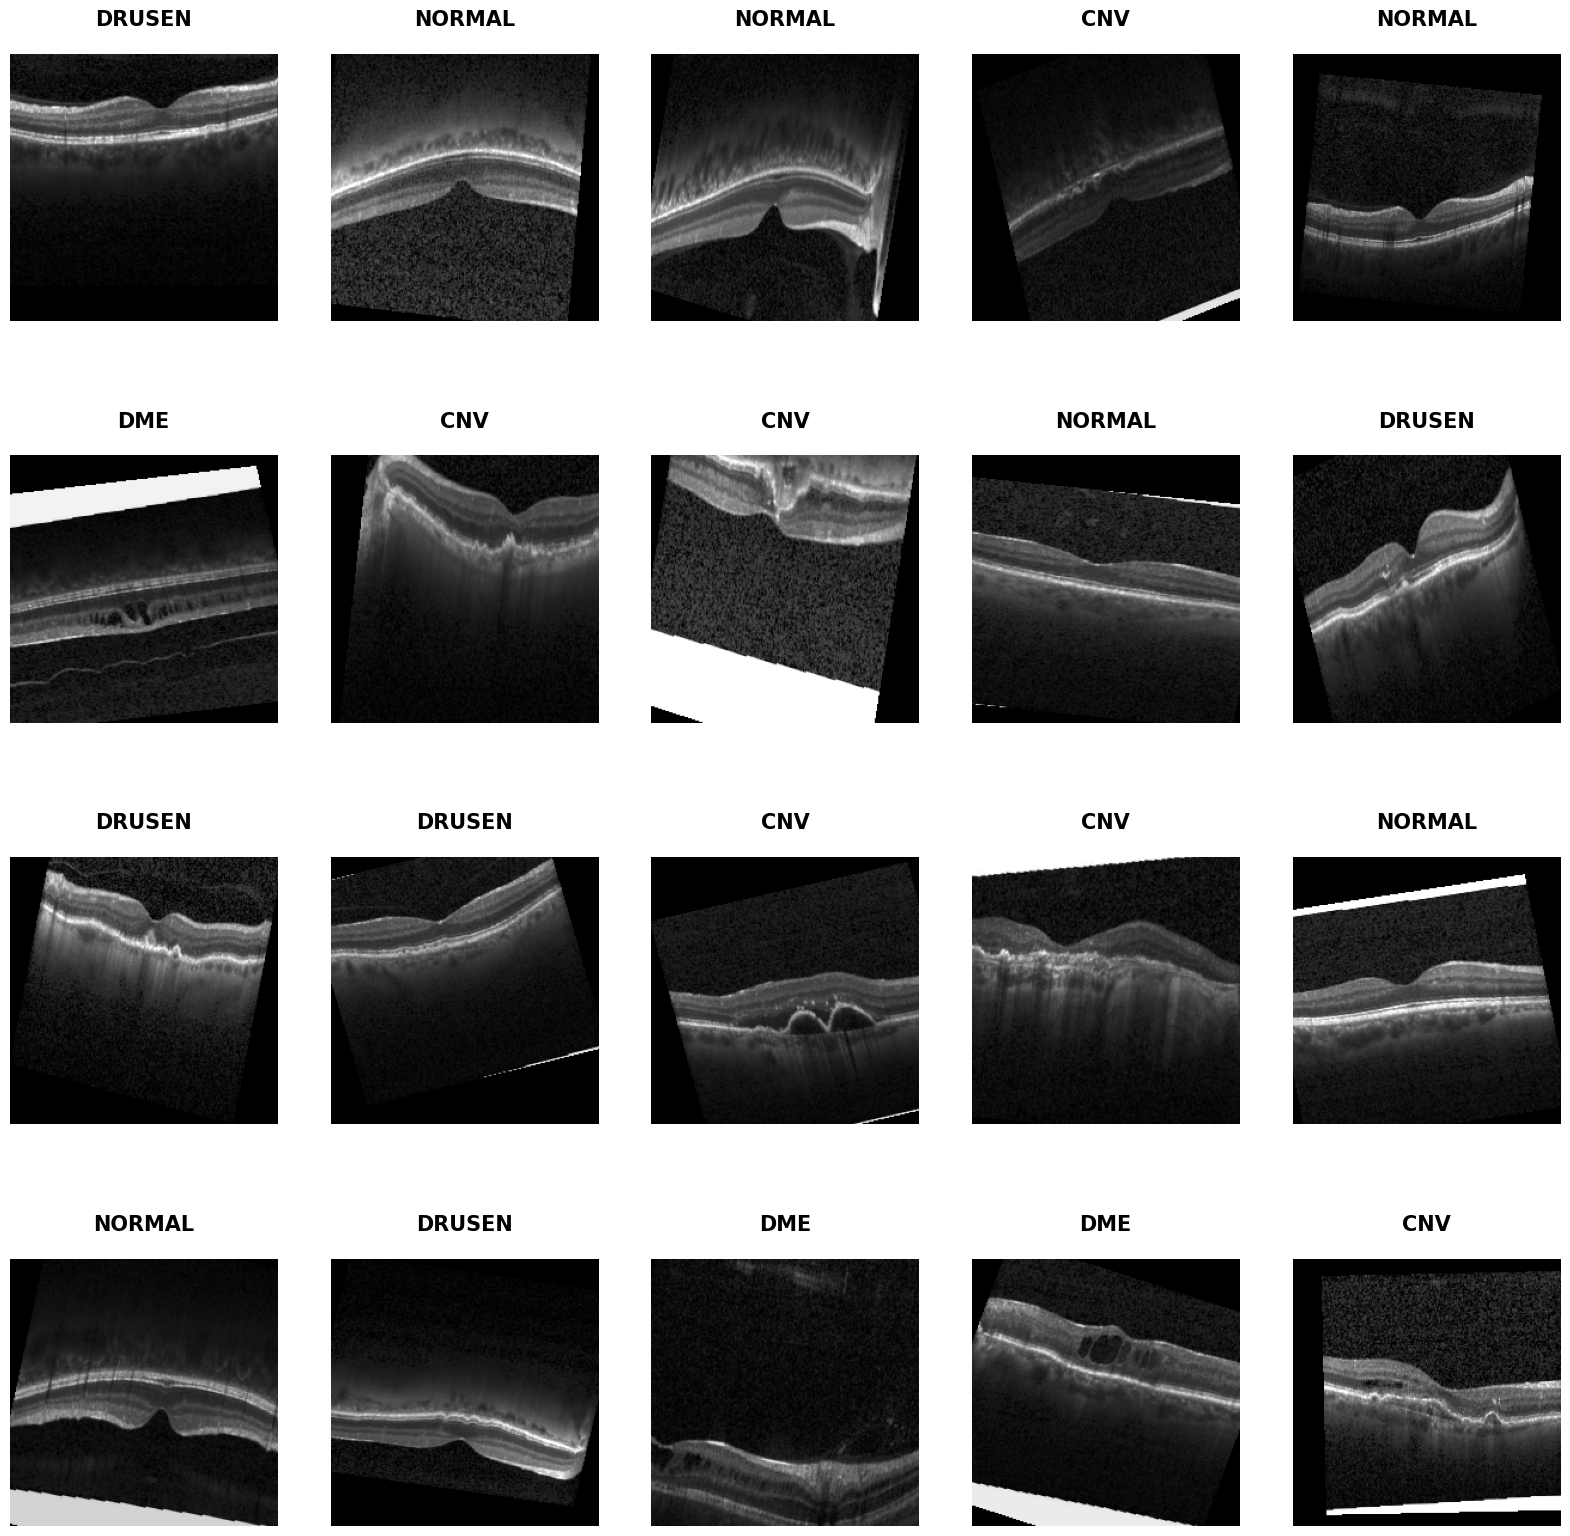

In [7]:
label_dict=train_generator.class_indices
disease=list(label_dict.keys())
images,labels=next(train_generator)
plt.figure(figsize=(20,20)),
rcParams['axes.titlepad']=20
for i in range(20):
    plt.subplot(4,5,i+1)
    image=images[i]
    plt.imshow(image)
    index=np.argmax(labels[i])
    disease_name=disease[index]
    plt.title(disease_name,fontsize=15,fontweight='bold')
    plt.axis('off')
plt.show()

Fine-tuning and Regularization

In [8]:
lr_reduce=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    mode='auto',
    min_lr=0
)
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='auto',
    min_delta=0.001
)
base_model=tf.keras.applications.VGG19(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(img_width,img_height,3),
                                                   classifier_activation='softmax'
                                                   )
for layer in base_model.layers:
    if 'block5' in layer.name:
        layer.trainable = True
#     elif 'block4' in layer.name:
#         layer.trainable = True
    else:
        layer.trainable=False
avg=tf.keras.layers.GlobalMaxPooling2D()(base_model.output)
reg=Dropout(0.45)(avg)
mid_l=Dense(128,activation='relu',kernel_initializer=HeNormal())(reg)
reg2=Dropout(0.45)(mid_l)
predictions=Dense(4,activation='softmax')(reg2)
model=Model(inputs=base_model.input,outputs=predictions)

80134624/80134624 [==============================] - 0s 0us/step


Training

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_reduce,early_stopping]
)

Epoch 1/20
82/82 [==============================] - 384s 5s/step - loss: 1.1385 - accuracy: 0.5159 - val_loss: 0.5951 - val_accuracy: 0.8072 - lr: 1.0000e-04
Epoch 2/20
82/82 [==============================] - 382s 5s/step - loss: 0.6241 - accuracy: 0.7780 - val_loss: 0.4216 - val_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 3/20
82/82 [==============================] - 375s 5s/step - loss: 0.4647 - accuracy: 0.8407 - val_loss: 0.3532 - val_accuracy: 0.8851 - lr: 1.0000e-04
Epoch 4/20
82/82 [==============================] - 377s 5s/step - loss: 0.4110 - accuracy: 0.8616 - val_loss: 0.3294 - val_accuracy: 0.8867 - lr: 1.0000e-04
Epoch 5/20
82/82 [==============================] - 374s 5s/step - loss: 0.3698 - accuracy: 0.8724 - val_loss: 0.3061 - val_accuracy: 0.8998 - lr: 1.0000e-04
Epoch 6/20
82/82 [==============================] - 375s 5s/step - loss: 0.3396 - accuracy: 0.8834 - val_loss: 0.3294 - val_accuracy: 0.8790 - lr: 1.0000e-04
Epoch 7/20
82/82 [==============================] - 

Testing

11/11 - 28s - loss: 0.0940 - accuracy: 0.9668 - 28s/epoch - 3s/step


[0.09396664053201675, 0.9668465852737427]

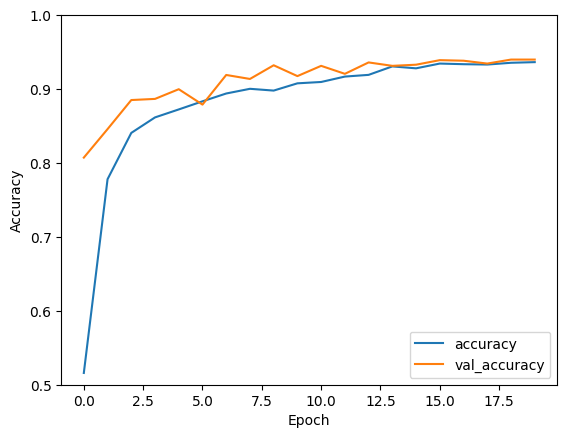

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

model.evaluate(test_generator, verbose=2)

11/11 [==============================] - 28s 2s/step


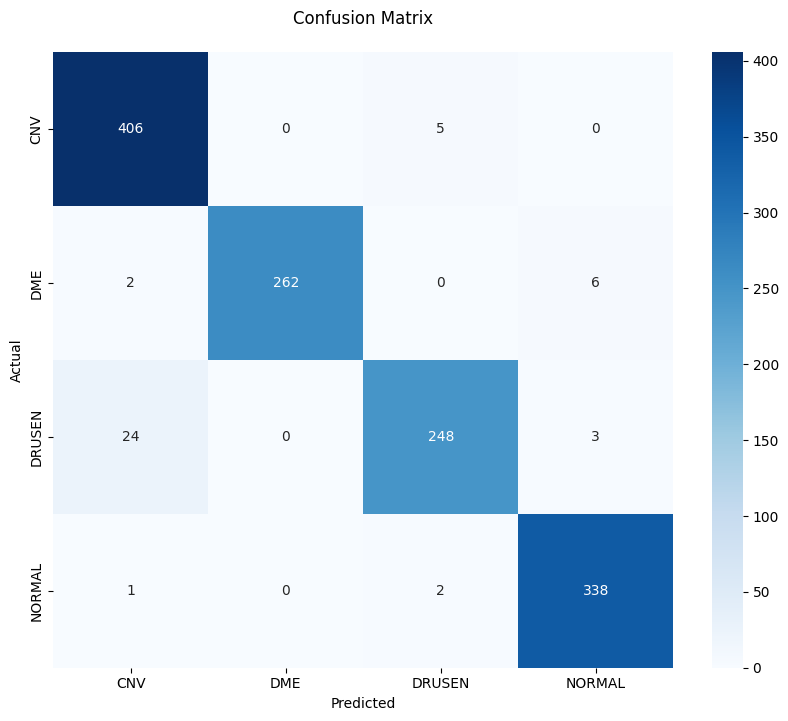

In [11]:
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:

pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names,output_dict=True))

,CNV,DME,DRUSEN,NORMAL,accuracy,macro avg,weighted avg
precision,0.937644,1.000000,0.972549,0.974063,0.966847,0.971064,0.967601
recall,0.987835,0.970370,0.901818,0.991202,0.966847,0.962806,0.966847
f1-score,0.962085,0.984962,0.935849,0.982558,0.966847,0.966364,0.966667
support,411.000000,270.000000,275.000000,341.000000,0.966847,1297.000000,1297.000000
